In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from modules import network,mlp,contrastive_loss
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 2000) (8569, 1)


,2,10,13,41,45,62,68,106,133,147,...,19763,19786,19808,19854,19883,20021,20073,20109,20121,20124
0,0.0,1.302199,0.0,0.0,0.0,0.000000,0.36896,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.637877,0.368960
1,0.0,1.351171,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.888292,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.711146,0.00000,0.0,0.0,0.0,...,0.0,0.417500,0.0,0.0,0.93785,0.0,0.0,0.0,0.937850,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.509045,0.00000,0.0,0.0,0.0,...,0.0,0.509045,0.0,0.0,0.00000,0.0,0.0,0.0,0.509045,0.509045


In [4]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

scGenDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

2000
1024
1024
2000
1024
1024


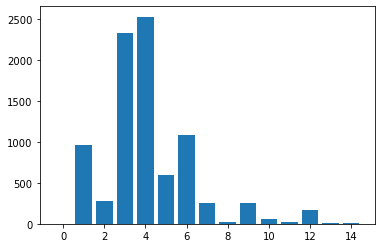

[   0.  958.  284. 2326. 2525.  601. 1077.  252.   18.  255.   55.   25.
  173.   13.    7.]


In [11]:
from matplotlib import pyplot as plt
y_count=np.zeros(args.classnum+1)
for i in range (0,args.classnum):
    y_count[i+1]=y_ndarray[y_ndarray==(i+1)].size

plt.bar(x=np.arange(0,len(y_count)),height=y_count)
plt.show()
print(y_count)
rare_y_index=[8,10,11,13,14]

In [5]:
class MemoryBank_Rare():

    # 初始化，传入参数
    def __init__(self,batch_size,full_data,topK=10):
        self.topK=topK
        self.batch_size=batch_size
        self.bank=None
        self.full_data=full_data

    # 根据在updateBank中更新的hnsw对象以及输入的数据data（这里可以是embedding）提取TopK个近邻的数据
    # 返回的结果是一个形状为[TopK,batch_size,num_genes]的数组，从第一个维度来看，
    # 每个[batch_size,num_genes]的子数组都是根据输入的数据data寻找的一个近邻，一共TopK个
    def generateContrast(self,data,label):
        if self.bank is not None:
            contrasts=np.empty((self.topK,args.batch_size,args.num_genes))
            (x_data,y_data)=self.full_data
            rare_index=np.where(y_data in )

            labels,distances=self.bank.knn_query(data,k=self.topK)
            
            # print(labels)

            for step,label in enumerate(labels):
                contrasts[:,step]=self.full_data[label.tolist()]
            return contrasts
        else:
            print('Memory Bank has not been initialized......')
            raise NotImplementedError()

    # 根据输入的embedding更新hnsw对象
    def updateBank(self,embedding):
        num_elements=len(embedding)
        dim=embedding.shape[1]
        self.bank=hnswlib.Index(space='cosine',dim=dim)
        self.bank.init_index(max_elements=num_elements, ef_construction=100, M=16)
        self.bank.set_ef(100)
        self.bank.set_num_threads(4)
        self.bank.add_items(embedding)

In [ ]:
for 

In [6]:
# initialize model
mlp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [8]:
memory_bank=MemoryBank_Rare(args.batch_size,full_data=zip(x_ndarray,y_ndarray),topK=10)
memory_bank.updateBank(x_ndarray)

In [9]:
for features,labels in scDataLoader:
    contrasts=memory_bank.generateContrast(data=features.numpy(),label=labels.numpy())

TypeError: 'zip' object is not subscriptable

In [ ]:
loss_epoch=0
for step,(data,label) in enumerate(scDataLoader):
    optimizer.zero_grad()
    
    # if epoch<20:
    embedding_data=data.numpy().copy()
    data=data.to('cuda')
    label=label.numpy().copy()
    # else:
    #     data=data.to('cuda')
    #     embedding_data=model.forward_embedding(data).cpu().detach().numpy()    
    contrast_samples=memory_bank.generateContrast(embedding_data)
    iter_times=contrast_samples.shape[0]
    for sample in contrast_samples:
        # print(f'sample shape:\n{sample.shape}')
        # print(f'data shape:\n{data.shape}')
        x_i=data.clone()
        x_j=torch.tensor(sample,dtype=torch.float32).to('cuda')

        z_i,z_j,c_i,c_j=model(x_i,x_j)
        loss_instance=instance_loss(z_i,z_j)
        loss_cluster=cluster_loss(c_i,c_j)
        loss = loss_instance + loss_cluster
        # print(f'------ loss:\n{loss}')
        loss.backward()
        optimizer.step()
        loss_epoch+=loss.item()
    if step % 2 == 0:
            print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")